#!pip install --upgrade seaborn
#!pip install --upgrade matplotlib pandas numpy

#!pip install --upgrade pycryptodome

In [11]:
#Importing packages
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras import backend as K
import itertools
#from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.layers.core import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,AveragePooling2D, Flatten, Dropout, Input, BatchNormalization
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)

# Data pre-processing

In [35]:
path = '/Users/kipkemoivincent/Desktop/Covid/Data3'

In [41]:
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 25000

horizontal_flip=True, 
                                                               vertical_flip=True,zoom_range=0.3,

In [42]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,validation_split=0.0001)
train_generator1 = train_datagen.flow_from_directory(path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='training')

Found 25000 images belonging to 5 classes.


In [28]:
validation_generator = train_datagen.flow_from_directory(path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=743,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='validation')

Found 0 images belonging to 5 classes.


In [16]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Colon adenocarcinoma
1 : Colon benign tissue
2 : Lung adenocarcinoma
3 : Lung benign tissue
4 : Lung squamous cell carcinoma


In [63]:
def report(arr1,arr2):
    print ('\x1b[6;30;46m'+'Accuracy:'+str(np.round(accuracy_score(arr1, arr2),4))+','+' Precision:'+str(np.round(precision_score(arr1, arr2),4))+','+
    ' Recall:'+str(np.round(recall_score(arr1, arr2),4))+','+' F1_score:'+str(np.round(f1_score(arr1, arr2),4)))
    return              

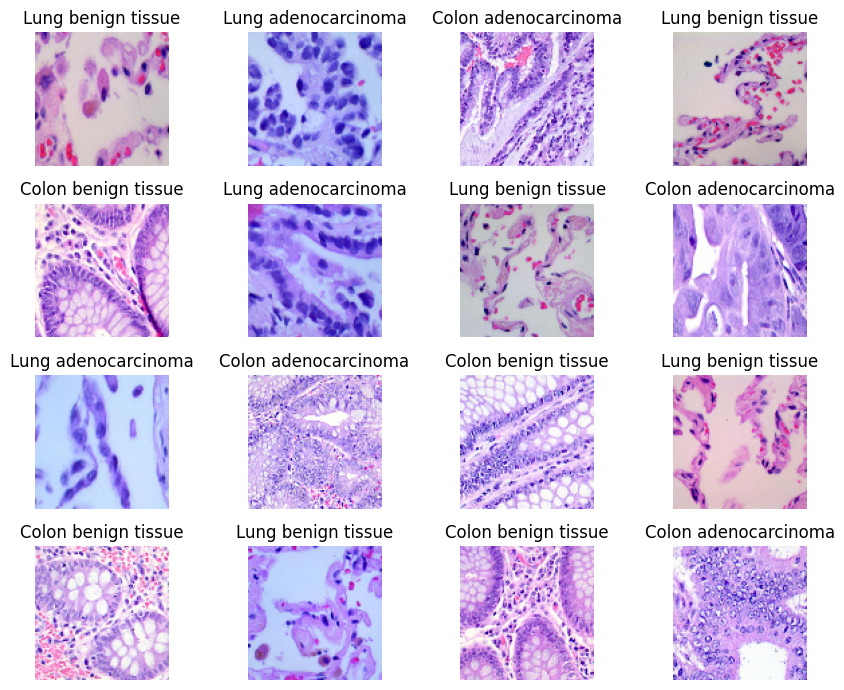

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(9, 7)) 
idx = 0

for i in range(4): 
    for j in range(4): 
        label = labels[np.argmax(train_generator[0][1][idx])] 
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :]) 
        ax[i, j].axis("off") 
        idx += 1

plt.tight_layout() 
#plt.suptitle("Sample Training Images", fontsize=21) 
plt.show()

In [43]:
X, y = next(train_generator1)
X=(X-X.mean())/X.std()
#X_test, y_test = next(validation_generator)

In [44]:
X.shape

(25000, 100, 100, 3)

In [45]:
from sklearn.model_selection import train_test_split
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

In [46]:
X_train1.shape

(22500, 100, 100, 3)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.20, random_state=42, shuffle=True)

In [48]:
X_train.shape,X_val.shape, X_test.shape

((18000, 100, 100, 3), (4500, 100, 100, 3), (2500, 100, 100, 3))

In [49]:
IMPUT_SHAPE=(IMG_WIDTH, IMG_HEIGHT, 3)

# Prediction using different Architectures

# A. CustomCNN

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
initializer = tf.keras.initializers.HeNormal()
values = initializer(shape=(2, 2))

2024-08-17 12:12:35.371965: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-17 12:12:35.427268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
from sklearn.utils import compute_class_weight
y=[np.argmax(i) for i in y_train]
class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y),y = y)
class_weights = dict(zip(np.unique(y), class_weights))

In [53]:
input_data = Input(shape=IMPUT_SHAPE)

#Convolution
x = Conv2D(32, (3, 3), activation="relu")(input_data)

#Pooling
x = MaxPooling2D(pool_size = (4, 4), strides=(4, 4))(x)

#Dropout
x = Dropout(0.25)(x)

# 2nd Convolution
x = Conv2D(32, (3, 3), activation="relu")(x)

# 2nd Pooling layer
x = MaxPooling2D(pool_size = (2, 2))(x)

#Dropout
x = Dropout(0.3)(x)

#3rd Convolution
x = Conv2D(32, (3, 3), activation='relu')(x)

#3rd Pooling Layer
x = MaxPooling2D(pool_size=(2, 2))(x)

#Dropout
x = Dropout(0.3)(x)

# Flatten the layer
x = Flatten()(x)

# Fully Connected Layers
x =Dense(128, activation = 'relu')(x)
output = Dense(5, activation = 'softmax')(x)

cnn =keras.models.Model(inputs=input_data, outputs=output)

# Compile the Neural network
cnn.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [54]:
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 32)        0     

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
filepath11="weights.best_custom_cnn1.hdf5"
checkpoint1 = ModelCheckpoint(filepath11, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list = [checkpoint1,es,rlrop]

In [56]:
history1 = cnn.fit(X_train,y_train,epochs = 100,verbose = 1,batch_size=4,
                  validation_data =(X_test,y_test),callbacks=callbacks_list,
                 class_weight=class_weights)

2024-08-17 12:13:01.619230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
4500/4500 [==============================] - 185s 40ms/step - loss: 0.7284 - accuracy: 0.6631 - val_loss: 0.3833 - val_accuracy: 0.8524

Epoch 00001: val_accuracy improved from -inf to 0.85240, saving model to weights.best_custom_cnn1.hdf5
Epoch 2/100
4500/4500 [==============================] - 141s 31ms/step - loss: 0.3403 - accuracy: 0.8597 - val_loss: 0.3319 - val_accuracy: 0.8660

Epoch 00002: val_accuracy improved from 0.85240 to 0.86600, saving model to weights.best_custom_cnn1.hdf5
Epoch 3/100
4500/4500 [==============================] - 126s 28ms/step - loss: 0.2754 - accuracy: 0.8886 - val_loss: 0.2645 - val_accuracy: 0.9056

Epoch 00003: val_accuracy improved from 0.86600 to 0.90560, saving model to weights.best_custom_cnn1.hdf5
Epoch 4/100
4500/4500 [==============================] - 125s 28ms/step - loss: 0.2426 - accuracy: 0.9018 - val_loss: 0.2339 - val_accuracy: 0.9180

Epoch 00004: val_accuracy improved from 0.90560 to 0.91800, saving model to weights.best_


Epoch 00037: val_accuracy did not improve from 0.99120
Epoch 38/100
4500/4500 [==============================] - 129s 29ms/step - loss: 0.0332 - accuracy: 0.9876 - val_loss: 0.0383 - val_accuracy: 0.9832

Epoch 00038: val_accuracy did not improve from 0.99120
Epoch 39/100
4500/4500 [==============================] - 126s 28ms/step - loss: 0.0380 - accuracy: 0.9867 - val_loss: 0.0278 - val_accuracy: 0.9912

Epoch 00039: val_accuracy did not improve from 0.99120
Epoch 40/100
4500/4500 [==============================] - 137s 30ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.0234 - val_accuracy: 0.9928

Epoch 00040: val_accuracy improved from 0.99120 to 0.99280, saving model to weights.best_custom_cnn1.hdf5
Epoch 41/100
4500/4500 [==============================] - 145s 32ms/step - loss: 0.0323 - accuracy: 0.9874 - val_loss: 0.0371 - val_accuracy: 0.9868

Epoch 00041: val_accuracy did not improve from 0.99280
Epoch 42/100
4500/4500 [==============================] - 126s 28ms/step 

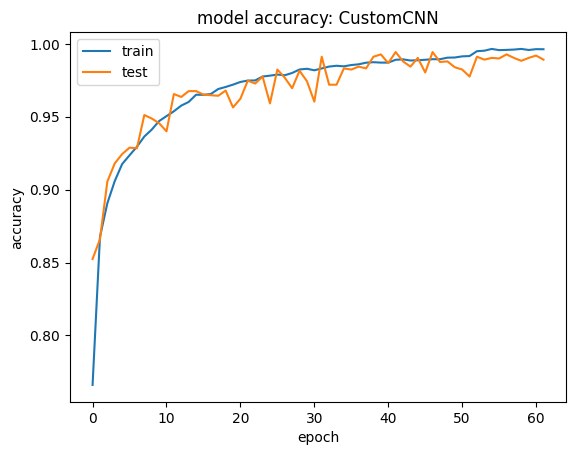

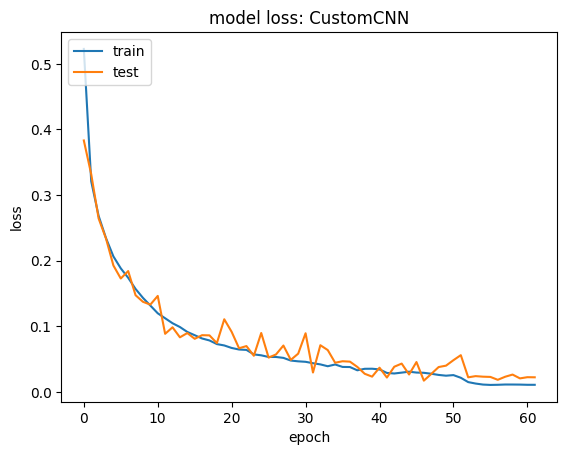

In [60]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy: CustomCNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss: CustomCNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [115]:
# load the saved model
from keras.models import load_model
cnn=load_model('weights.best_custom_cnn1.hdf5')

In [116]:
pred1=cnn.predict(X_test)
Pred=[np.argmax(i) for i in pred1]
Y_test=[np.argmax(i) for i in y_test]

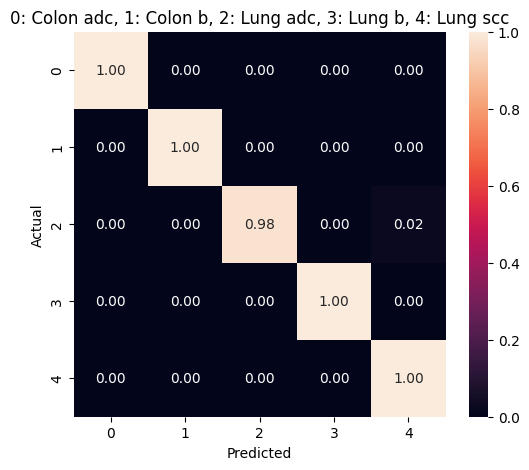

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: Colon adc, 1: Colon b, 2: Lung adc, 3: Lung b, 4: Lung scc')
plt.show(block=False)

In [118]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "customCNN.h5")
# load and evaluate a saved model
loaded_model = models.load_model('customCNN.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

In [119]:
acc1=np.round(accuracy_score(Y_test, Pred),4)
acc1

0.9944

# B. MobileNetV2 

In [73]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def make_mobilenet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
# Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(5, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [74]:
filepath21="weights.best_mobile_net.hdf5"
checkpoint2 = ModelCheckpoint(filepath21, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es2 = EarlyStopping(monitor='val_accuracy', patience=10)
rlrop2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list2 = [checkpoint2,es2,rlrop2]

In [75]:
# Define a model using the make_model function
image_size = (100,100,3)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 2)

# Preview the Model Summary
mobilenet_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645 

In [76]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']

mobilenet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [77]:
history2= mobilenet_model.fit(X_train, y_train,batch_size = 4, epochs = 100, validation_data = (X_val, y_val), 
                                                callbacks=callbacks_list2, class_weight=class_weights)

Epoch 1/100
4500/4500 [==============================] - 256s 56ms/step - loss: 0.4817 - accuracy: 0.8328 - val_loss: 0.1263 - val_accuracy: 0.9564

Epoch 00001: val_accuracy improved from -inf to 0.95644, saving model to weights.best_mobile_net.hdf5
Epoch 2/100
4500/4500 [==============================] - 339s 75ms/step - loss: 0.1425 - accuracy: 0.9487 - val_loss: 0.1052 - val_accuracy: 0.9622

Epoch 00002: val_accuracy improved from 0.95644 to 0.96222, saving model to weights.best_mobile_net.hdf5
Epoch 3/100
4500/4500 [==============================] - 278s 62ms/step - loss: 0.1026 - accuracy: 0.9602 - val_loss: 0.0964 - val_accuracy: 0.9633

Epoch 00003: val_accuracy improved from 0.96222 to 0.96333, saving model to weights.best_mobile_net.hdf5
Epoch 4/100
4500/4500 [==============================] - 267s 59ms/step - loss: 0.0933 - accuracy: 0.9632 - val_loss: 0.0807 - val_accuracy: 0.9704

Epoch 00004: val_accuracy improved from 0.96333 to 0.97044, saving model to weights.best_mob

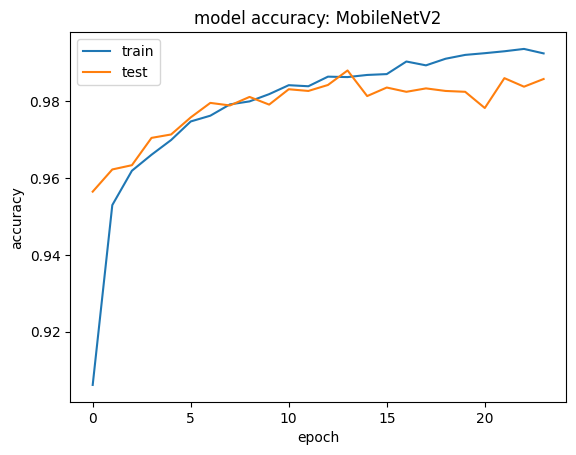

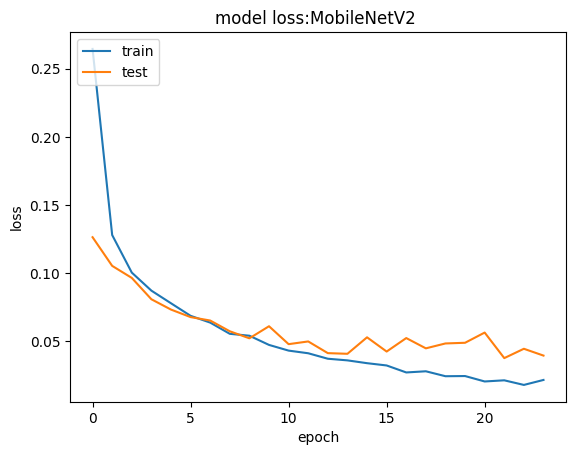

In [78]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy: MobileNetV2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss:MobileNetV2 ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [120]:
mobilenet_model=load_model('weights.best_mobile_net.hdf5')

In [121]:
pred2=mobilenet_model.predict(X_test)
Pred=[np.argmax(i) for i in pred2]
Y_test=[np.argmax(i) for i in y_test]

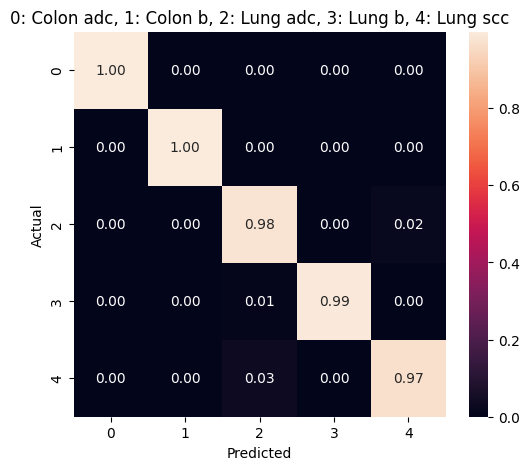

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: Colon adc, 1: Colon b, 2: Lung adc, 3: Lung b, 4: Lung scc')
plt.show(block=False)

In [123]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "Mobilenetv2.h5")
# load and evaluate a saved model
loaded_model = models.load_model('Mobilenetv2.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

In [124]:
acc2=np.round(accuracy_score(Y_test, Pred),42)
acc2

0.9868

# C: DenseNet169

In [102]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [103]:
from tensorflow.keras.applications import DenseNet169

In [104]:
def make_densenet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.DenseNet169(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    # Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(5, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [105]:
image_size = (100,100,3)
densenet_model = make_densenet_model(image_size, num_classes = 2)

# Preview the Model Summary
densenet_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 3, 3, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1664)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               213120    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645 

In [112]:
filepath31="weights.best_densenet169.hdf5"
checkpoint3 = ModelCheckpoint(filepath31, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es3 = EarlyStopping(monitor='val_accuracy', patience=5)
rlrop3 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5)
callbacks_list3 = [checkpoint3,es3,rlrop3]

In [113]:
densenet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [114]:
history3 = densenet_model.fit(X_train, y_train,epochs = 100,verbose = 1,batch_size=4,validation_data =(X_val,y_val)
                    ,callbacks=callbacks_list3,class_weight=class_weights)

Epoch 1/100
4500/4500 [==============================] - 729s 159ms/step - loss: 0.0895 - accuracy: 0.9644 - val_loss: 0.0674 - val_accuracy: 0.9756

Epoch 00001: val_accuracy improved from -inf to 0.97556, saving model to weights.best_densenet169.hdf5
Epoch 2/100
 117/4500 [..............................] - ETA: 9:25 - loss: 0.0820 - accuracy: 0.9683

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy: DenseNet169')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss: DenseNet169')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
model=load_model('weights.best_densenet169.hdf5')

In [126]:
pred3=model.predict(X_test)
Pred=[np.argmax(i) for i in pred3]
Y_test=[np.argmax(i) for i in y_test]

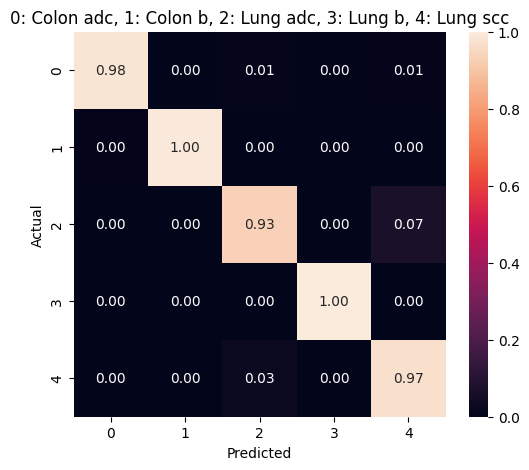

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: Colon adc, 1: Colon b, 2: Lung adc, 3: Lung b, 4: Lung scc')
plt.show(block=False)

In [128]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "DenseNet169.h5")
# load and evaluate a saved model
loaded_model = models.load_model('DenseNet169.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

In [129]:
acc3=np.round(accuracy_score(Y_test, Pred),42)
acc3

0.976

# D: ResNet50

def make_resnet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    # Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(5, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

image_size = (100,100,3)
resnet_model = make_resnet_model(image_size, num_classes = 2)

# Preview the Model Summary
resnet_model.summary()

filepath51="weights.best_ResNet50.hdf5"
checkpoint4 = ModelCheckpoint(filepath51, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es4 = EarlyStopping(monitor='val_accuracy', patience=10)
rlrop4 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list4 = [checkpoint4,es4,rlrop4]

base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']

resnet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history4 = resnet_model.fit(X_train, y_train,epochs = 6,verbose = 1,batch_size=4,validation_data =(X_val,y_val)
                    ,callbacks=callbacks_list4,class_weight=class_weights)

# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy: ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss: ResNet50')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model=load_model('weights.best_ResNet50.hdf5')

pred4=model.predict(X_test)
Pred=[np.argmax(i) for i in pred4]
Y_test=[np.argmax(i) for i in y_test]

from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: Colon adc, 1: Colon b, 2: Lung adc, 3: Lung b, 4: Lung scc')
plt.show(block=False)

from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "ResNet50.h5")
# load and evaluate a saved model
loaded_model = models.load_model('ResNet50.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

acc4=np.round(accuracy_score(Y_test, Pred),42)
acc4

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CustomCNN', 'MobileNetV2','DenseNet169'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CustomCNN', 'MobileNetV2','DenseNet169'], loc='upper right')
plt.show()

# ENSEMBLE

To create an ensemble of the four models, we will stack their predictions and use Microsoft FLAML AutoML to find an optimal combiner.

In [138]:
X_data=np.concatenate([pred1,pred2,pred3], axis=1)
y_data= np.argmax(y_test, axis=1)
X_data.shape, y_data.shape

((2500, 15), (2500,))

In [153]:
from flaml import AutoML
automl = AutoML()
estimator_list = ['rf','lgbm']
automl_settings = {
    "time_budget": 20,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": 24545678,  # random seed
    "metric":  'accuracy',  # evaluation metric
    "estimator_list": estimator_list,  # specify the list of estimators
}
automl.fit(X_train=X_data, y_train=y_data, **automl_settings)

[flaml.automl.logger: 08-17 18:17:46] {1680} INFO - task = classification
[flaml.automl.logger: 08-17 18:17:46] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 08-17 18:17:46] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 08-17 18:17:46] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm']
[flaml.automl.logger: 08-17 18:17:46] {2219} INFO - iteration 0, current learner rf
[flaml.automl.logger: 08-17 18:17:46] {2345} INFO - Estimated sufficient time budget=1629s. Estimated necessary time budget=2s.
[flaml.automl.logger: 08-17 18:17:46] {2392} INFO -  at 0.3s,	estimator rf's best error=0.1688,	best estimator rf's best error=0.1688
[flaml.automl.logger: 08-17 18:17:46] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-17 18:17:46] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 08-17 18:17:46] {2219} INFO - iteration 2, current learner lgbm
[flaml

[flaml.automl.logger: 08-17 18:17:51] {2219} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 08-17 18:17:51] {2392} INFO -  at 5.2s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:51] {2219} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 08-17 18:17:51] {2392} INFO -  at 5.4s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:51] {2219} INFO - iteration 37, current learner lgbm
[flaml.automl.logger: 08-17 18:17:51] {2392} INFO -  at 5.6s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:51] {2219} INFO - iteration 38, current learner lgbm
[flaml.automl.logger: 08-17 18:17:51] {2392} INFO -  at 5.7s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:51] {2219} INFO - iteration 39, current learner lgbm
[flaml.automl

[flaml.automl.logger: 08-17 18:17:57] {2219} INFO - iteration 72, current learner lgbm
[flaml.automl.logger: 08-17 18:17:57] {2392} INFO -  at 11.4s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:57] {2219} INFO - iteration 73, current learner rf
[flaml.automl.logger: 08-17 18:17:57] {2392} INFO -  at 11.6s,	estimator rf's best error=0.0032,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:57] {2219} INFO - iteration 74, current learner rf
[flaml.automl.logger: 08-17 18:17:58] {2392} INFO -  at 11.7s,	estimator rf's best error=0.0032,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:58] {2219} INFO - iteration 75, current learner lgbm
[flaml.automl.logger: 08-17 18:17:58] {2392} INFO -  at 11.9s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:17:58] {2219} INFO - iteration 76, current learner lgbm
[flaml.automl.log

[flaml.automl.logger: 08-17 18:18:02] {2392} INFO -  at 16.6s,	estimator rf's best error=0.0032,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:18:02] {2219} INFO - iteration 109, current learner lgbm
[flaml.automl.logger: 08-17 18:18:02] {2392} INFO -  at 16.7s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:18:02] {2219} INFO - iteration 110, current learner lgbm
[flaml.automl.logger: 08-17 18:18:03] {2392} INFO -  at 16.8s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:18:03] {2219} INFO - iteration 111, current learner lgbm
[flaml.automl.logger: 08-17 18:18:03] {2392} INFO -  at 17.0s,	estimator lgbm's best error=0.0024,	best estimator lgbm's best error=0.0024
[flaml.automl.logger: 08-17 18:18:03] {2219} INFO - iteration 112, current learner rf
[flaml.automl.logger: 08-17 18:18:03] {2392} INFO -  at 17.1s,	estimator rf's best error=0.0032,

In [147]:
pred5=automl.predict(X_data)

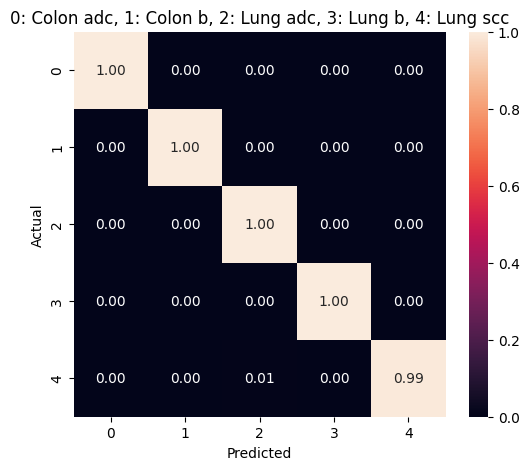

In [148]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(y_data, pred5)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0: Colon adc, 1: Colon b, 2: Lung adc, 3: Lung b, 4: Lung scc')
plt.show(block=False)

In [149]:
acc4=np.round(accuracy_score(y_data, pred5),42)
acc4

0.998

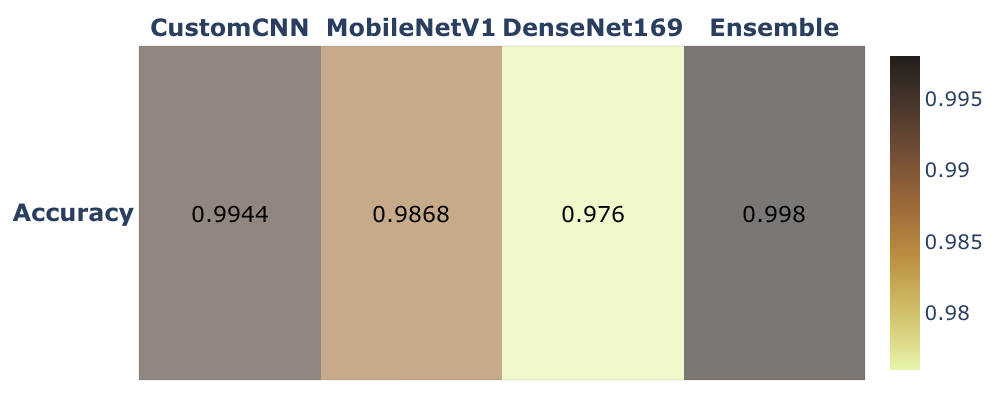

In [152]:
import plotly.graph_objects as go
from functools import reduce
from itertools import product
from IPython.display import Image
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
z=[ [acc1,acc2,acc3,acc4]]
x=['<b>CustomCNN</b>', '<b>MobileNetV1</b>', '<b>DenseNet169</b>',  '<b>Ensemble</b>']
y=['<b>Accuracy</b>']

def get_anno_text(z_value):
    annotations=[]
    a, b = len(z_value), len(z_value[0])
    flat_z = reduce(lambda x,y: x+y, z_value) # z_value.flat if you deal with numpy
    coords = product(range(a), range(b))
    for pos, elem in zip(coords, flat_z):
        annotations.append({'font': {'color': 'black'},
                    'showarrow': False,
                    'text': str(elem),
                    'x': pos[1],
                    'y': pos[0],
                        'font.size':22   })
    return annotations

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True, colorscale ='turbid',
    opacity=0.6,colorbar=dict(tickfont=dict(size=20)) ))#matter#

fig.update_layout(title={'text': "",
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
           plot_bgcolor='rgba(0,0,0,0)',       
    annotations = get_anno_text(z),
                 width=1000,
height=400,xaxis={'side': 'top'},margin=dict(l=20, r=20, t=20, b=20))

fig.update_xaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
    
                 mirror=True)
fig.update_yaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
        
                 mirror=True)
fig.write_image("table2d.png")
#plt.savefig("table2a.pdf", format="pdf", bbox_inches="tight")
fig.show()
Image('table2d.png')